<a href="https://colab.research.google.com/github/chrisliu01/network-management/blob/master/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSCI 6706 Summer - Assignment 3 - Chris Liu - B00415613

> Indented block


- Note: this part is inspired by Lab 6 and 7




Data Preprocssing


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving datasets.csv to datasets (10).csv


In [ ]:

# RUN ALL THE CODE BEFORE YOU START
import numpy as np
from matplotlib.pylab import plt #load plot library
import pandas as pd
import io
# indicate the output of plotting function is printed to the notebook
%matplotlib inline 

# FullMesh_y = [8.045, 20.281, 17.721, 20.281, 22.865, 32.314]
# DropAlgorithm_y = [52.004, 64.585, 86.985]
# NewDesign_y = [30.738, 61.910, 47.367, 38.983]
# reading csv file  
# df_day_one=pd.read_csv(io.BytesIO(uploaded['2020-06-07-8-05PM_00002_20200607210636_labeled.csv']))
# ###
# df_day_one.head()

# reading csv file  
# df_day_two=pd.read_csv(io.BytesIO(uploaded['2020-06-08-9-04AM_00002_20200608100431_labeled.csv']))
# ###
# df_day_two.head()

# df_day_three=pd.read_csv(io.BytesIO(uploaded['2020-06-09-4-02PM_00002_20200609170231_labeled.csv']))
# df_day_three.head()

# df_total = df_day_one
# df_total.append(df_day_two, ignore_index=True)
# df_total.append(df_day_three, ignore_index=True)

# df_total=pd.read_csv(io.BytesIO(uploaded['assignment2-df-total.csv']))
# df_total.head()

# df_lls_ddos = pd.read_csv(io.BytesIO(uploaded['LLS_DDOS_1.0-dmz.csv']))
# df_lls_ddos.head()

df_snort = pd.read_csv(io.BytesIO(uploaded['datasets.csv']))
df_snort.head(6)




,dataset,duration,packages,whitelist,alerts,admingain,DoS,vulnerableweb,informationleak,querydecode,badtraffic,miscattack
0,dmz-before,1779.467369,362321,15384,1223,38,0,18,29,160,0,123
1,dmz-after-dos,1742.783990,336040,6981,6697,37,5498,16,25,156,20,124
2,dmz-after-dos-acl,1797.763877,337259,6984,0,0,0,0,0,0,0,0
3,inside-before,1741.573787,562229,7155,394,17,0,16,27,89,5,19
4,inside-after-dos,1826.109403,507537,6701,4753,37,5498,16,25,156,20,124
5,inside-after-dos-acl,2051.108195,529726,6656,0,0,0,0,0,0,0,0


Visualization

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


              DstAddr TotPkts
                          sum
4478    172.16.115.20   41933
3708   172.16.112.194   23179
4834    194.7.248.153   22623
3164      131.84.1.31   22318
4312    172.16.114.50   21597
4842   197.218.177.69   19162
4057    172.16.113.50   18362
3803    172.16.112.50   17346
3180     135.8.60.182   15442
4836  195.115.218.108   11387


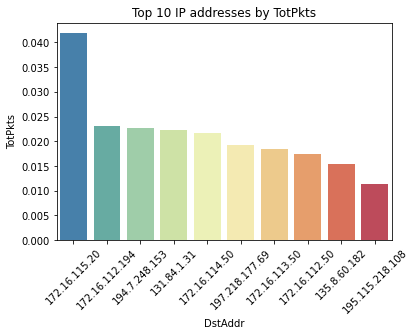

In [ ]:

def srcAddPkgs(df):
  f, ax = plt.subplots(1, 1,figsize=(6, 4))

  per_ip = df.groupby("DstAddr", as_index=False).agg({"TotPkts":[np.sum]})

  p = per_ip.sort_values(by=("TotPkts","sum"),ascending=False)[:10]
  print(p)
  p["TotPkts","sum"] = p["TotPkts","sum"]/1000000
  sns.barplot(p["DstAddr"], p["TotPkts","sum"],palette="Spectral_r", ax=ax)

  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
  ax.set_ylabel("TotPkts")
  ax.set_title("Top 10 IP addresses by TotPkts")

srcAddPkgs(df_lls_ddos)

             DstAddr          Load
                               sum
4312   172.16.114.50  4.398420e+08
3605  172.16.112.100  3.597730e+08
5280    209.67.29.11  3.409950e+08
5210   207.46.130.14  2.813516e+08
5196   207.25.71.141  2.603720e+08
5161   206.132.25.51  1.807246e+08
4864    199.95.74.90  1.355599e+08
5202   207.25.71.200  1.171785e+08
5144  205.181.112.65  1.163783e+08
4816  192.208.46.111  1.132706e+08


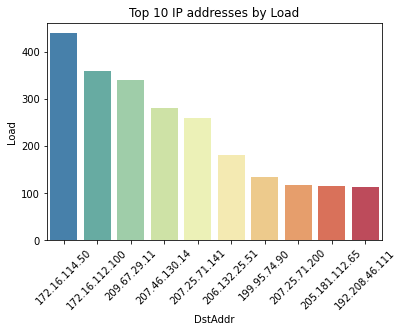

In [ ]:

def srcAddLoad(df):
  f, ax = plt.subplots(1, 1,figsize=(6, 4))

  per_ip = df.groupby("DstAddr", as_index=False).agg({"Load":[np.sum]})

  p = per_ip.sort_values(by=("Load","sum"),ascending=False)[:10]
  print(p)
  p["Load","sum"] = p["Load","sum"]/1000000
  sns.barplot(p["DstAddr"], p["Load","sum"],palette="Spectral_r", ax=ax)

  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
  ax.set_ylabel("Load")
  ax.set_title("Top 10 IP addresses by Load")

srcAddLoad(df_lls_ddos)

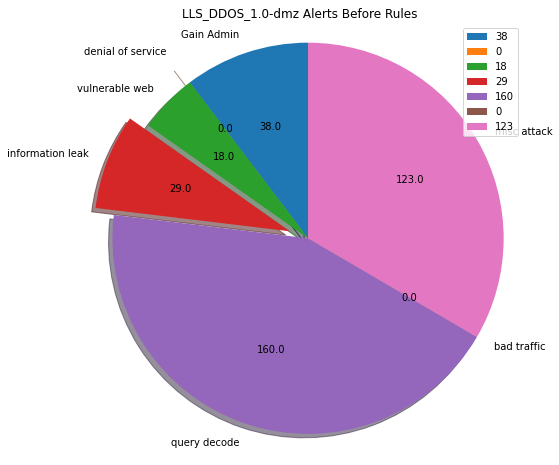

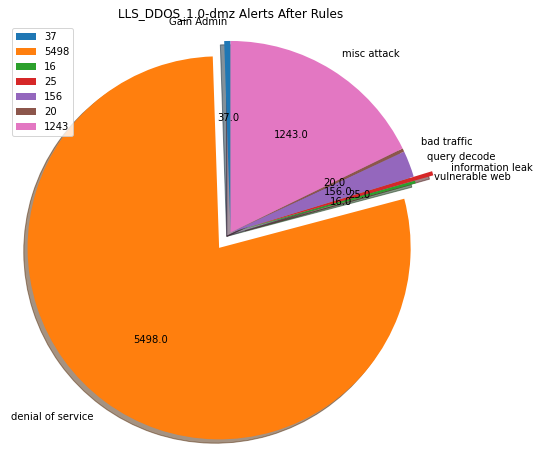

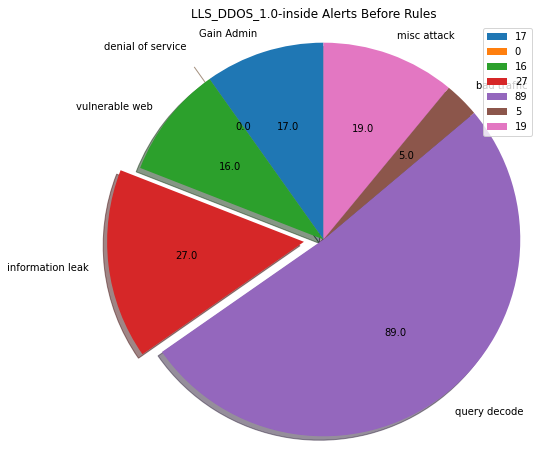

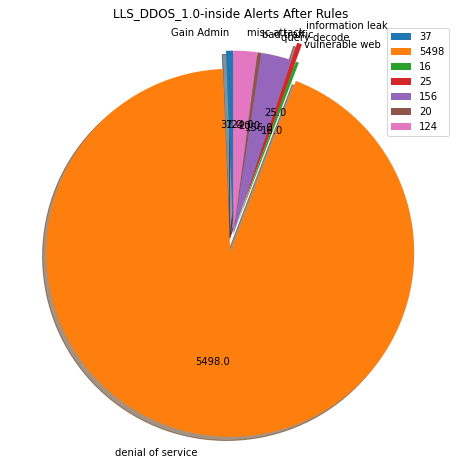

In [ ]:
###snort data analytics****
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import collections



def snortPie(values, title):
    labels = ['Gain Admin','denial of service','vulnerable web','information leak','query decode','bad traffic','misc attack']
    sizes = np.array(values)
    explode = (0, 0.1, 0, 0.1, 0, 0, 0) 

    def absolute_value(val):
        a  = np.round(val/100.*sizes.sum(), 0)
        return a
#autopct='%1.1f%%', 
    fig1, ax1 = plt.subplots(1, 1,figsize=(8, 8))
    patches, texts, _ = ax1.pie(sizes, explode=explode, labels=labels, autopct=absolute_value, shadow=True, startangle=90)
    plt.legend(patches, sizes, loc="best")
    ax1.axis('equal') 
    plt.title(title)
    plt.show()

####dmz-before
snortPie([38,	0,	18,	29,	160,	0,	123],'LLS_DDOS_1.0-dmz Alerts Before Rules')
####dmz-after-dos-rule
snortPie([37,	5498,	16,	25,	156,	20,	1243],'LLS_DDOS_1.0-dmz Alerts After Rules')

####dmz-before
snortPie([17,	0,	16,	27,	89,	5,	19],'LLS_DDOS_1.0-inside Alerts Before Rules')
####dmz-after-dos-rule
snortPie([37,	5498,	16,	25,	156,	20,	124],'LLS_DDOS_1.0-inside Alerts After Rules')

In [ ]:
df_snort.columns

Index(['dataset', 'duration', 'packages', 'whitelist', 'alerts', 'admingain',
       'DoS', 'vulnerableweb', 'informationleak', 'querydecode', 'badtraffic',
       'miscattack'],
      dtype='object')

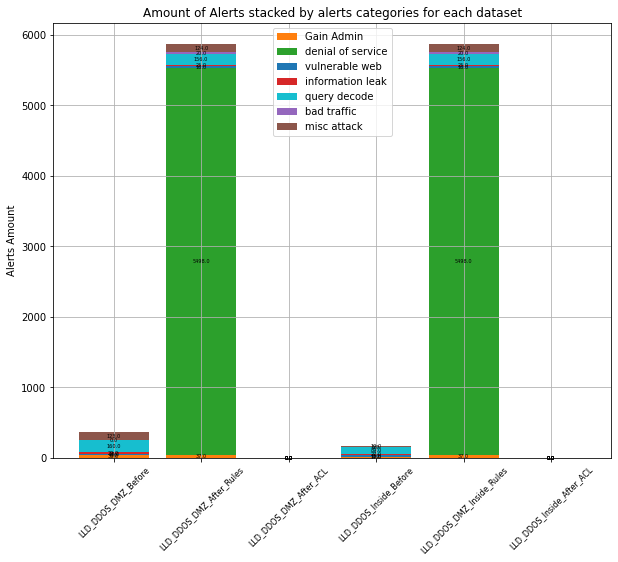

In [ ]:
# plot snorts alert of each alert category (https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib)
def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=True, reverse=False):
  
    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels, rotation=45, fontsize=8)
        # ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center",fontsize=5)
                
def snortStackedBar(df_snort, title): 
    plt.figure(figsize=(10, 8))

    labels = ['Gain Admin','denial of service','vulnerable web','information leak','query decode','bad traffic','misc attack']
    labels_colors = ['tab:orange', 'tab:green', 'tab:blue', 'tab:red', 'tab:cyan', 'tab:purple', 'tab:brown']

    data = [
        df_snort.admingain,
        df_snort.DoS,
        df_snort.vulnerableweb,
        df_snort.informationleak,
        df_snort.querydecode,
        df_snort.badtraffic,
        df_snort.miscattack
    ]

    datasets = ['LLD_DDOS_DMZ_Before', 'LLD_DDOS_DMZ_After_Rules', 'LLD_DDOS_DMZ_After_ACL', 'LLD_DDOS_Inside_Before', 'LLD_DDOS_DMZ_Inside_Rules', 'LLD_DDOS_Inside_After_ACL']

    plot_stacked_bar(
        data, 
        labels, 
        category_labels=datasets, 
        show_values=True, 
        value_format="{:.1f}",
        colors=labels_colors,
        y_label="Alerts Amount"
    )

    plt.title(title)
    plt.show()

snortStackedBar(df_snort, 'Amount of Alerts stacked by alerts categories for each dataset')